# SYDE 552 Assignment 4: Basal Ganglia
### Due Monday, April 8, 11:59pm
### Value: 15% of total marks for the course

This assignment covers various forms of Action Selection, covering a standard feed-forward neural network model and a winner-take-all model.  The last section adds biological details to the winner-take-all model (synapses).  The intent is to show the creation a modification of small specific-purpose networks and to explore how timing affects neurons.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. Action Selection with Feed-forward Neural Networks

In order for the brain to choose which of many possible actions to select to perform at any given moment, it needs to be able to takke a list of numbers (indicating how good each action is in the current state, sometimes called the Value) and create an output that indicates which one is the largest.  For example, with the input `[0.2, 0.5, 0.8, 0.3]` we might want the output `[0, 0, 1, 0]`.  

One way to approach this task is to train a normal feed-forward neural network on this task.  This would be similar to the digit recognition task from Assignment 2, except we would just have the list of values as input instead of the image.

To create the dataset for training the network, we can just generate a random set of values between 0 and 1, and then compute which one is biggest to produce our target value.

In [2]:
import numpy as np

N = 4        # how many values in the list
M = 10000    # how many random examples to make in the dataset

X = np.random.uniform(0,1,(M,N))
Y = np.argmax(X, axis=1)

In order to train with this data in pytorch, we need to turn that array into a pytorch dataset, and to split it into training and testing.


In [3]:
import torch
dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Y).long()) # create your datset

train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)


Now we have to define our network.  Here we define a simple neural network with 4 inputs, a hidden layer of 100 neurons, and 4 outputs.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_layer_size=100):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, hidden_layer_size)    # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(hidden_layer_size, 4)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return x
    
network = Net()

Finally, we have to train the model.  Here is the exact same code from Assignment 2 for training


In [5]:
# create the learning rule
optimizer = torch.optim.SGD(network.parameters(), 
                            lr=0.1,   # learning rate
                            momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)
    
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)


**1. a) [1 mark]** Call `continue_training()` 10 times and then plot the training and testing accuracy (as you did in assignment 2 question 3a.

In [6]:
# Call continue_training 10 times
for i in range(10):
    continue_training()

Iteration 1 Training accuracy: 0.257999986410141
Iteration 1 Testing accuracy: 0.2535000145435333
Iteration 2 Training accuracy: 0.257999986410141
Iteration 2 Testing accuracy: 0.2535000145435333
Iteration 3 Training accuracy: 0.257999986410141
Iteration 3 Testing accuracy: 0.2535000145435333
Iteration 4 Training accuracy: 0.257999986410141
Iteration 4 Testing accuracy: 0.2535000145435333
Iteration 5 Training accuracy: 0.24275000393390656
Iteration 5 Testing accuracy: 0.2475000023841858
Iteration 6 Training accuracy: 0.24275000393390656
Iteration 6 Testing accuracy: 0.2475000023841858
Iteration 7 Training accuracy: 0.24275000393390656
Iteration 7 Testing accuracy: 0.2475000023841858
Iteration 8 Training accuracy: 0.24275000393390656
Iteration 8 Testing accuracy: 0.2475000023841858
Iteration 9 Training accuracy: 0.24275000393390656
Iteration 9 Testing accuracy: 0.2475000023841858
Iteration 10 Training accuracy: 0.24275000393390656
Iteration 10 Testing accuracy: 0.2475000023841858


In [7]:
import matplotlib.pyplot as plt

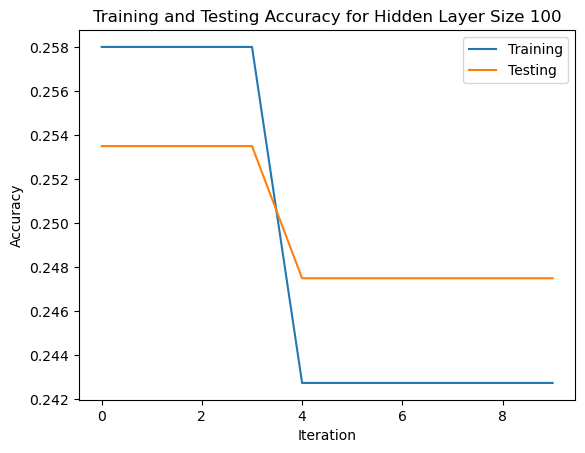

In [8]:
# Plot training and testing accuracy
plt.title('Training and Testing Accuracy for Hidden Layer Size 100')
plt.plot(accuracy_train, label='Training')
plt.plot(accuracy_test, label='Testing')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**1. b) [1 mark]** In the previous question, the model did not get a very high accuracy.  To try to improve the accuracy, let's vary the number of neurons.  Try using 200 neurons, 500 neurons, and 1000 neurons.  For each one, generate the same plot as in 1a.  Does making the network larger in this way improve performance significantly?

In [9]:
def train_eval_model(hidden_size):
  network = Net(hidden_size)
  optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
  
  for i in range(10):
      continue_training()
  return accuracy_train, accuracy_test

In [10]:
layer_sizes = [200, 500, 1000]
train_accs = []
test_accs = []
for size in layer_sizes:
    print('Training with hidden layer size', size)
    accuracy_train = []
    accuracy_test = []
    train_acc, test_acc = train_eval_model(size)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

Training with hidden layer size 200
Iteration 1 Training accuracy: 0.24275000393390656
Iteration 1 Testing accuracy: 0.2475000023841858
Iteration 2 Training accuracy: 0.24275000393390656
Iteration 2 Testing accuracy: 0.2475000023841858
Iteration 3 Training accuracy: 0.24275000393390656
Iteration 3 Testing accuracy: 0.2475000023841858
Iteration 4 Training accuracy: 0.24275000393390656
Iteration 4 Testing accuracy: 0.2475000023841858
Iteration 5 Training accuracy: 0.24275000393390656
Iteration 5 Testing accuracy: 0.2475000023841858
Iteration 6 Training accuracy: 0.24275000393390656
Iteration 6 Testing accuracy: 0.2475000023841858
Iteration 7 Training accuracy: 0.24275000393390656
Iteration 7 Testing accuracy: 0.2475000023841858
Iteration 8 Training accuracy: 0.24275000393390656
Iteration 8 Testing accuracy: 0.2475000023841858
Iteration 9 Training accuracy: 0.24275000393390656
Iteration 9 Testing accuracy: 0.2475000023841858
Iteration 10 Training accuracy: 0.24275000393390656
Iteration 10

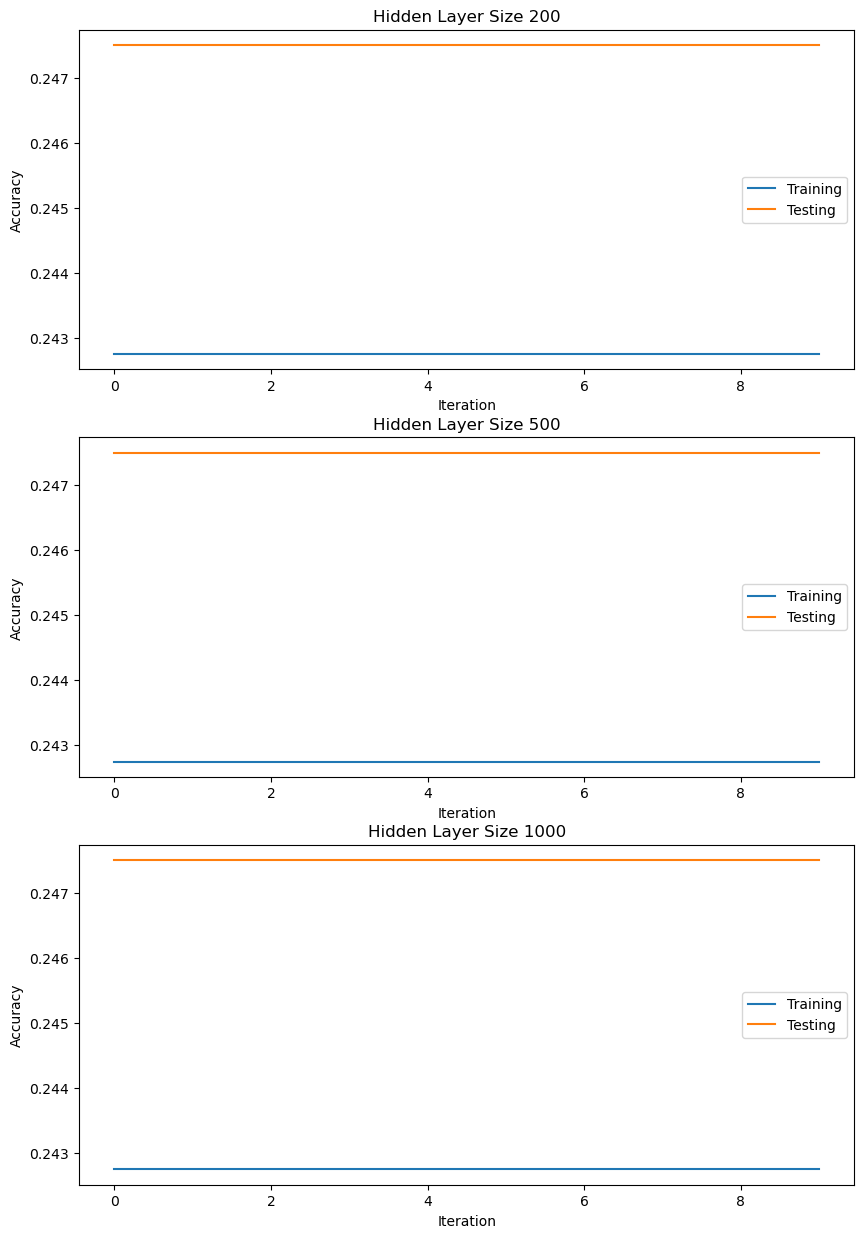

In [11]:
num_plots = len(layer_sizes)
# plt.subplots(num_plots, 1)
plt.figure(figsize=(10, 5*num_plots))
for i in range(num_plots):
    plt.subplot(num_plots, 1, i+1)
    plt.title('Hidden Layer Size ' + str(layer_sizes[i]))
    plt.plot(train_accs[i], label='Training')
    plt.plot(test_accs[i], label='Testing')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()

We see that changing the network size doesn't improve the network's performance. None of the single layer networks perform well.

**1. c) [1 mark]** Try making the network deeper by adding a second layer of neurons.  Use 500 neurons in each of the two middle layers.  Generate the same plot as in 1a.  Does making the network larger in this way improve performance significantly?

In [12]:
class Two_Layer_Net(nn.Module):
    def __init__(self, hidden_layer_size=500):
        super(Two_Layer_Net, self).__init__()
        self.fc1 = nn.Linear(4, hidden_layer_size)    # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)    # the weights from the hidden layer to the hidden layer
        self.fc3 = nn.Linear(hidden_layer_size, 4)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = F.relu(self.fc2(x))         # apply the second set of weights
        x = self.fc3(x)                 # apply the third set of weights
        return x

In [13]:
network = Two_Layer_Net()

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)

accuracy_train = []
accuracy_test = []

for i in range(10):
    continue_training()

Iteration 1 Training accuracy: 0.24275000393390656
Iteration 1 Testing accuracy: 0.2475000023841858
Iteration 2 Training accuracy: 0.24275000393390656
Iteration 2 Testing accuracy: 0.2475000023841858
Iteration 3 Training accuracy: 0.24275000393390656
Iteration 3 Testing accuracy: 0.2475000023841858
Iteration 4 Training accuracy: 0.24275000393390656
Iteration 4 Testing accuracy: 0.2475000023841858
Iteration 5 Training accuracy: 0.24275000393390656
Iteration 5 Testing accuracy: 0.2475000023841858
Iteration 6 Training accuracy: 0.24275000393390656
Iteration 6 Testing accuracy: 0.2475000023841858
Iteration 7 Training accuracy: 0.24275000393390656
Iteration 7 Testing accuracy: 0.2475000023841858
Iteration 8 Training accuracy: 0.24275000393390656
Iteration 8 Testing accuracy: 0.2475000023841858
Iteration 9 Training accuracy: 0.24275000393390656
Iteration 9 Testing accuracy: 0.2475000023841858
Iteration 10 Training accuracy: 0.24275000393390656
Iteration 10 Testing accuracy: 0.247500002384185

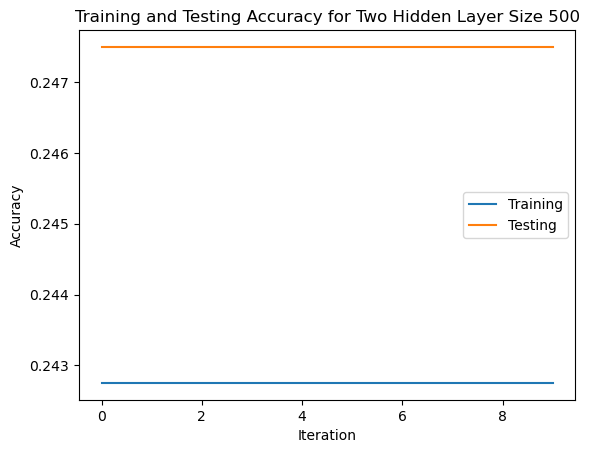

In [14]:
# Plot training and testing accuracy
plt.title('Training and Testing Accuracy for Two Hidden Layer Size 500')
plt.plot(accuracy_train, label='Training')
plt.plot(accuracy_test, label='Testing')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Adding a second layer doesn't improve the network's performance at all.

**1. d) [1 mark]** Starting with the original model in question 1a, let's modify the network in a different way.  In particular, in the current version of the model we have no neuron model at the output.  This is due to this part of the code:

```python
    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return x
```

For the first line (the hidden layer), we use a Rectified Linear neuron model (`F.relu`).  But we aren't doing that with the second line, where it creates the output.  Let's try adding a neuron model there by changing `x = self.fc2(x)` to `x = F.relu(self.fc2(x))`.

Train the model again (by calling `continue_training` 10 times) and make the same plot as above.  Does this improve performance significantly?

In [15]:
class Net(nn.Module):
    def __init__(self, hidden_layer_size=100):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, hidden_layer_size)    # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(hidden_layer_size, 4)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = F.relu(self.fc2(x))                 # apply the second set of weights
        return x

In [16]:
network = Net()

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)

accuracy_train = []
accuracy_test = []

for i in range(10):
    continue_training()

Iteration 1 Training accuracy: 0.257999986410141
Iteration 1 Testing accuracy: 0.2535000145435333
Iteration 2 Training accuracy: 0.257999986410141
Iteration 2 Testing accuracy: 0.2535000145435333
Iteration 3 Training accuracy: 0.257999986410141
Iteration 3 Testing accuracy: 0.2535000145435333
Iteration 4 Training accuracy: 0.257999986410141
Iteration 4 Testing accuracy: 0.2535000145435333
Iteration 5 Training accuracy: 0.24275000393390656
Iteration 5 Testing accuracy: 0.2475000023841858
Iteration 6 Training accuracy: 0.24275000393390656
Iteration 6 Testing accuracy: 0.2475000023841858
Iteration 7 Training accuracy: 0.24275000393390656
Iteration 7 Testing accuracy: 0.2475000023841858
Iteration 8 Training accuracy: 0.24275000393390656
Iteration 8 Testing accuracy: 0.2475000023841858
Iteration 9 Training accuracy: 0.24275000393390656
Iteration 9 Testing accuracy: 0.2475000023841858
Iteration 10 Training accuracy: 0.24275000393390656
Iteration 10 Testing accuracy: 0.2475000023841858


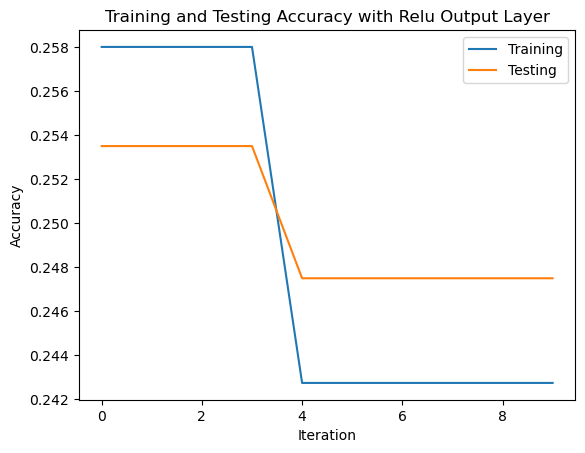

In [17]:
# Plot training and testing accuracy
plt.title('Training and Testing Accuracy with Relu Output Layer')
plt.plot(accuracy_train, label='Training')
plt.plot(accuracy_test, label='Testing')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

No, adding a ReLU activation doesn't significantly improve the performance of the model.

**1. e) [1 mark]** Repeat 1.d but use `F.sigmoid` instead of `F.relu` for the output.  Plot the same graph as before.  You should see that this change makes an improvement over the results in the previous questions.  Why is this the case?

In [18]:
class Net_Sigmoid(nn.Module):
    def __init__(self, hidden_layer_size=100):
        super(Net_Sigmoid, self).__init__()
        self.fc1 = nn.Linear(4, hidden_layer_size)    # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(hidden_layer_size, 4)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = F.sigmoid(self.fc2(x))                 # apply the second set of weights
        return x

In [19]:
network = Net_Sigmoid()

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)

accuracy_train = []
accuracy_test = []

for i in range(10):
    continue_training()

Iteration 1 Training accuracy: 0.6216250061988831
Iteration 1 Testing accuracy: 0.6169999837875366
Iteration 2 Training accuracy: 0.6113749742507935
Iteration 2 Testing accuracy: 0.6060000061988831
Iteration 3 Training accuracy: 0.5992500185966492
Iteration 3 Testing accuracy: 0.5950000286102295
Iteration 4 Training accuracy: 0.5929999947547913
Iteration 4 Testing accuracy: 0.5830000042915344
Iteration 5 Training accuracy: 0.5881249904632568
Iteration 5 Testing accuracy: 0.5774999856948853
Iteration 6 Training accuracy: 0.5836250185966492
Iteration 6 Testing accuracy: 0.5715000033378601
Iteration 7 Training accuracy: 0.5817499756813049
Iteration 7 Testing accuracy: 0.5665000081062317
Iteration 8 Training accuracy: 0.5776249766349792
Iteration 8 Testing accuracy: 0.5644999742507935
Iteration 9 Training accuracy: 0.578125
Iteration 9 Testing accuracy: 0.5625
Iteration 10 Training accuracy: 0.5756250023841858
Iteration 10 Testing accuracy: 0.5615000128746033


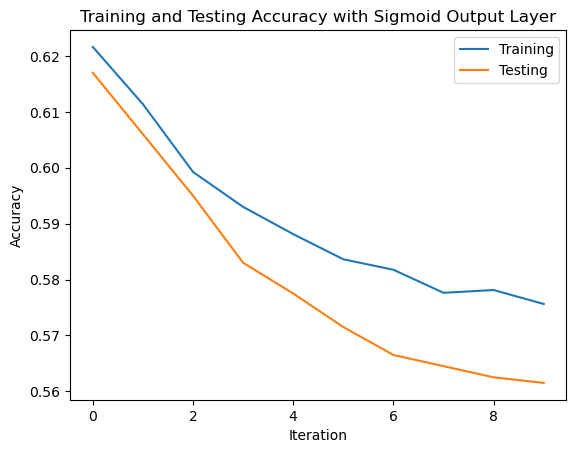

In [20]:
# Plot training and testing accuracy
plt.title('Training and Testing Accuracy with Sigmoid Output Layer')
plt.plot(accuracy_train, label='Training')
plt.plot(accuracy_test, label='Testing')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Yes, we see that the model improves significantly with the sigmoid activation over all previous results. This makes sense because the sigmoid function drives values to 0 and 1 which are the desired outputs for this task. Therefore the network only needs to drive the highest value as high as possible and the remaining values low then the sigmoid will correct it to 0 and 1.

**1. f) [1 mark]** Try replacing the `F.sigmoid` with `F.softmax`.  The softmax function will scale up the largest value while scaling down the smaller values.  Repeat the previous question and plot the same graph.  You should see an even bigger improvement.  Why is this the case?  

In [21]:
class Net_Softmax(nn.Module):
    def __init__(self, hidden_layer_size=100):
        super(Net_Softmax, self).__init__()
        self.fc1 = nn.Linear(4, hidden_layer_size)    # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(hidden_layer_size, 4)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = F.softmax(self.fc2(x))                 # apply the second set of weights
        return x

In [22]:
network = Net_Softmax()

optimizer = torch.optim.SGD(network.parameters(), lr=0.1, momentum=0.5)

accuracy_train = []
accuracy_test = []

for i in range(10):
    continue_training()

/var/folders/2s/9hjjm87j7ldc54rw3_f_pfcm0000gn/T/ipykernel_32080/1933105348.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))                 # apply the second set of weights


Iteration 1 Training accuracy: 0.5774999856948853
Iteration 1 Testing accuracy: 0.5899999737739563
Iteration 2 Training accuracy: 0.8771250247955322
Iteration 2 Testing accuracy: 0.8939999938011169
Iteration 3 Training accuracy: 0.9441249966621399
Iteration 3 Testing accuracy: 0.9480000138282776
Iteration 4 Training accuracy: 0.9627500176429749
Iteration 4 Testing accuracy: 0.9635000228881836
Iteration 5 Training accuracy: 0.9750000238418579
Iteration 5 Testing accuracy: 0.9750000238418579
Iteration 6 Training accuracy: 0.9794999957084656
Iteration 6 Testing accuracy: 0.9819999933242798
Iteration 7 Training accuracy: 0.9822499752044678
Iteration 7 Testing accuracy: 0.9819999933242798
Iteration 8 Training accuracy: 0.984125018119812
Iteration 8 Testing accuracy: 0.9879999756813049
Iteration 9 Training accuracy: 0.9866250157356262
Iteration 9 Testing accuracy: 0.9854999780654907
Iteration 10 Training accuracy: 0.9866250157356262
Iteration 10 Testing accuracy: 0.9884999990463257


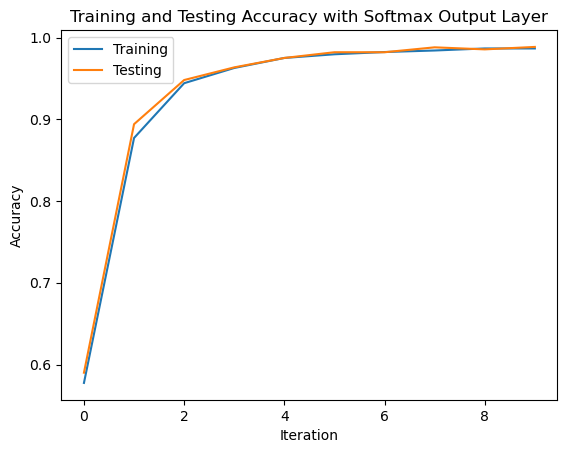

In [23]:
# Plot training and testing accuracy
plt.title('Training and Testing Accuracy with Softmax Output Layer')
plt.plot(accuracy_train, label='Training')
plt.plot(accuracy_test, label='Testing')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We see that the network performs extremely well, this makes sense because the the softmax function is scaling up the largest values while scaling down the other values within the range of 0 and 1, this is the exact task that the network is supposed to be doing.

**1. g) [1 mark]** Even though the model you built in 1f) does a good job of solving the task of producing the correct output, it seems to do this only if we include a `softmax` operation.  How might this be considered "cheating" (and thus this should not considered to be a good model of action selection in the brain)? 

The model in 1g) might be considered cheating because the softmax operation is doing the task that the network is meant to be accomplishingh thus it doesn't suggest that the neural circuit is a good model for what is going on in the brain.

# 2. Action Selection with Winner-Take-All

Given the results of the previous section, we need a different approach to do action selection.  Since a feed-forward approach led to difficulties, here we will explore a recurrent network: the standard "winner-take-all" circuit.  In this system, each neuron excites itself but inhibits the other neurons.

Crucially, since this approach is recurrent, we can't just feed in an input and get an output.  Instead, we will feed in an input over time and see what the output is over time.  Rather than implement this in `pytorch`, we will just use normal numpy commands.

The main configurable part of the model is how nuch the neurons excite themselves and how much they inhibit other neurons.  We can build this as a weight matrix that has the excitation on the diagonal and the inhibition everywhere else:


In [24]:
w = np.zeros((N,N))
w[:] = -0.9   # set the inhibition amount everywhere
for i in range(N):
    w[i,i] = 1   # set the excitatory connection
    
print(w)

[[ 1.  -0.9 -0.9 -0.9]
 [-0.9  1.  -0.9 -0.9]
 [-0.9 -0.9  1.  -0.9]
 [-0.9 -0.9 -0.9  1. ]]


To run the model, we pick a particular input that set that we will provide.  We then feed that value into the model, and add the value that the neurons send back to themselves.  We also include a `clip` operation that stops the neuron value from going below 0 or above 1.  We repeat this process multiple times, and we record the activity of the neurons so we can plot it afterwards.

In [25]:
record = []                   # for recording the activity values
activity = np.zeros(N)        # neurons are not active initially
input_values = np.zeros(N)    # empty input so it doesn't crash
for i in range(10):
    # the new neuron value is the old value times the weight matrix (for the neurons 
    #  inhibiting and exciting each other), plus the input benig added.
    # we also clip the neurons so their activity doesn't go below 0 or above 1
    activity = np.clip(input_values + w @ activity, 0, 1)
    record.append(activity)

**2. a) [1 mark]**  Run the model with an input of `[0.7, 0.8, 0.4, 0.3]`.  Plot the `record` of the activity.  Print the final `activity` value.  Does the network successfully output the desired correct results of `[0, 1, 0, 0]`?

In [26]:
def winner_take_all(input_values, w, iterations=10):
    record = []                   # for recording the activity values
    activity = np.zeros(N)        # neurons are not active initially
    for i in range(iterations):
        # the new neuron value is the old value times the weight matrix (for the neurons 
        #  inhibiting and exciting each other), plus the input benig added.
        # we also clip the neurons so their activity doesn't go below 0 or above 1
        activity = np.clip(input_values + w @ activity, 0, 1)
        record.append(activity)
    # Return the final activity values
    return record[-1], record

In [27]:
input_values = np.array([0.7, 0.8, 0.4, 0.3])
output, record = winner_take_all(input_values, w)
print(output)

[0. 1. 0. 0.]


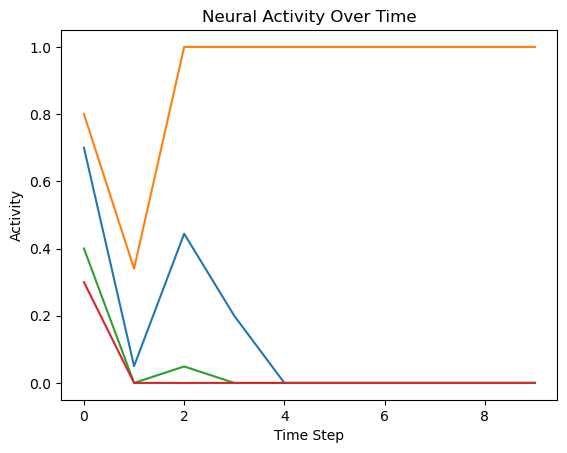

In [28]:
# Plot the activity of each neuron over time
record = np.array(record)
plt.plot(record)
plt.xlabel('Time Step')
plt.ylabel('Activity')
plt.title('Neural Activity Over Time')
plt.show()

In [29]:
print('Final activity:')
print(record[-1])

Final activity:
[0. 1. 0. 0.]


In [30]:
print(record[4])

[0. 1. 0. 0.]


Yes, we see that the model produces the correct output at the end. In fact, we can see that the model reaches the correct output by timestep 4.

**2. b) [1 mark]**  Test the model using all the data in the `X` dataset you created in question 1.  (This should be all 10000 sets of 4 randomly generated numbers).  Note that since we didn't use any data to train the model, we are using all of it to test the model.

To test the model, loop through all the items (`for input_values in X:`) and run the model as in question 2a.  To determine if the output is correct, you can do

```python
    target = np.zeros(N)
    target[np.argmax(input_values)] = 1
    if np.all(target == activity):
        correct += 1
```

What proportion of the time does the model produce the correct output?

In [31]:
# Test network with all 10000 examples
correct = 0
for input_values in X:
    output, _ = winner_take_all(input_values, w)
    target = np.zeros(N)
    target[np.argmax(input_values)] = 1
    if np.all(target == output):
        correct += 1
accuracy = correct / M
print('Accuracy:', accuracy)

Accuracy: 0.8019


We find that the model produces the right accuracy approximately 80% of the time.

**2. c) [1 mark]**  Try running the model for a longer time, rather than the 10 steps in the code provided.  Try 10, 20, 50, 100, 200, and 500.  Make a plot showing the proportion of time the model produces the ideal output for each of those numbers of timesteps.

In [32]:
# Create function to test network with different iterations
def test_iterations(iterations, w=w):
    correct = 0
    for input_values in X:
        output, _ = winner_take_all(input_values, w, iterations)
        target = np.zeros(N)
        target[np.argmax(input_values)] = 1
        if np.all(target == output):
            correct += 1
    accuracy = correct / M
    return accuracy

In [33]:
num_iterations = [10, 20, 50, 100, 200, 500]
accuracies = []
for iterations in num_iterations:
    print('Testing with', iterations, 'iterations')
    accuracy = test_iterations(iterations)
    accuracies.append(accuracy)

Testing with 10 iterations
Testing with 20 iterations
Testing with 50 iterations
Testing with 100 iterations
Testing with 200 iterations
Testing with 500 iterations


In [34]:
print(accuracies)

[0.8019, 0.854, 0.8742, 0.8785, 0.8808, 0.8819]


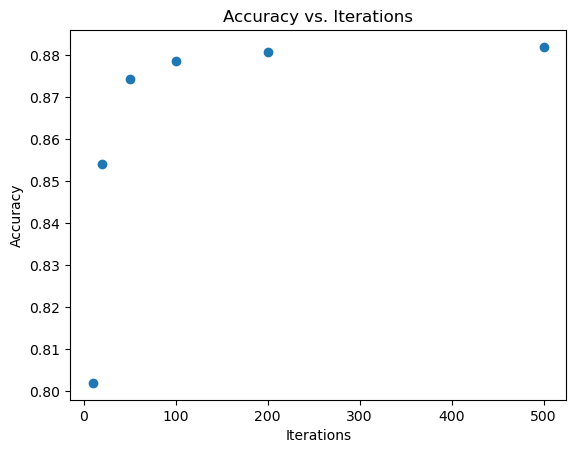

In [35]:
plt.scatter(num_iterations, accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations')
plt.show()

**2. d) [2 marks]**  Try improving the model by adjusting the amount of inhibition (-0.9) and the amount of excitation (1).  Can you improve the proportion of time the model produces the correction output?  To simplify your experimentation, keep the number of timesteps as 20.

In [36]:
# Adjust the amount of inhibition and excitation
# Test with num_iterations = 20
def test_excit_inhit(excit, inhit):
  w = np.zeros((N,N))
  w[:] = inhit   # set the inhibition amount everywhere
  for i in range(N):
      w[i,i] = excit   # set the excitatory connection
  accuracy = test_iterations(20, w)
  return accuracy

In [50]:
excit_values = [0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2]
inhit_values = [-0.8, -0.85, -0.9, -0.95, -1, -1.05, -1.1, -1.15, -1.2]
accuracies = np.zeros((len(excit_values), len(inhit_values)))
for i, excit in enumerate(excit_values):
    for j, inhit in enumerate(inhit_values):
        print('Testing with excit:', excit, 'inhit:', inhit)
        accuracy = test_excit_inhit(excit, inhit)
        print('Accuracy:', accuracy)
        accuracies[i,j] = accuracy

Testing with excit: 0.8 inhit: -0.8
Accuracy: 0.7754
Testing with excit: 0.8 inhit: -0.85
Accuracy: 0.8051
Testing with excit: 0.8 inhit: -0.9
Accuracy: 0.8038
Testing with excit: 0.8 inhit: -0.95
Accuracy: 0.7685
Testing with excit: 0.8 inhit: -1
Accuracy: 0.7188
Testing with excit: 0.8 inhit: -1.05
Accuracy: 0.6573
Testing with excit: 0.8 inhit: -1.1
Accuracy: 0.6017
Testing with excit: 0.8 inhit: -1.15
Accuracy: 0.5513
Testing with excit: 0.8 inhit: -1.2
Accuracy: 0.5024
Testing with excit: 0.85 inhit: -0.8
Accuracy: 0.7843
Testing with excit: 0.85 inhit: -0.85
Accuracy: 0.8173
Testing with excit: 0.85 inhit: -0.9
Accuracy: 0.8253
Testing with excit: 0.85 inhit: -0.95
Accuracy: 0.7974
Testing with excit: 0.85 inhit: -1
Accuracy: 0.7512
Testing with excit: 0.85 inhit: -1.05
Accuracy: 0.6941
Testing with excit: 0.85 inhit: -1.1
Accuracy: 0.6342
Testing with excit: 0.85 inhit: -1.15
Accuracy: 0.5836
Testing with excit: 0.85 inhit: -1.2
Accuracy: 0.5363
Testing with excit: 0.9 inhit: -0

In [51]:
# Find highest accuracy
max_accuracy = np.max(accuracies)
print('Max accuracy:', max_accuracy)
# Find indices of highest accuracy
max_index = np.argmax(accuracies)
max_indices = np.unravel_index(max_index, accuracies.shape)
print('Max index:', max_index)
print('Max indices:', max_indices)

# Find excit and inhit values that produced highest accuracy
best_excit = excit_values[max_indices[0]]
best_inhit = inhit_values[max_indices[1]]
print('Best excit:', best_excit)
print('Best inhit:', best_inhit)

Max accuracy: 0.8595
Max index: 57
Max indices: (6, 3)
Best excit: 1.1
Best inhit: -0.95


In [52]:
# Compare to original values (-0.9, 1)
print('Original accuracy:', accuracies[2,1])

Original accuracy: 0.8265


We see that the accuracy improves from 0.8265 to 0.8595 when we adjust the excitation and inhibition values to 1.1, -0.95

# 3. Action Selection with Winner-Take-All and a Synapse

We are now going to add a biological detail to the Winner-Take-All system.  In biology, when there is a connection between neurons, there is a synapse, and the activity of that synapse decays slowly over time.  This means that when a spike occurs, the input into the next neuron will suddenly increase, and then slowly decrease.

Here we will make a simple approximation of this process.  We will be implementing this as a *low-pass filter*.  The only parameter is the one that controls how quickly the synaptic activity will decay, and we will call this `tau`.  To implement a low-pass filter as part of our neuron model, we can compute the synaptic activity as follows, where `dt` is how long one timestep is in our model:

```python
alpha = 1-np.exp(-dt/tau)

activity_syn = activity_syn + alpha * (activity - activity_syn)
```

Here is what that would look like for a single input that gave a single spike on the 5th timestep, where each timestep is 0.001 seconds and the synaptic time constant is 0.01 seconds (10 milliseconds):



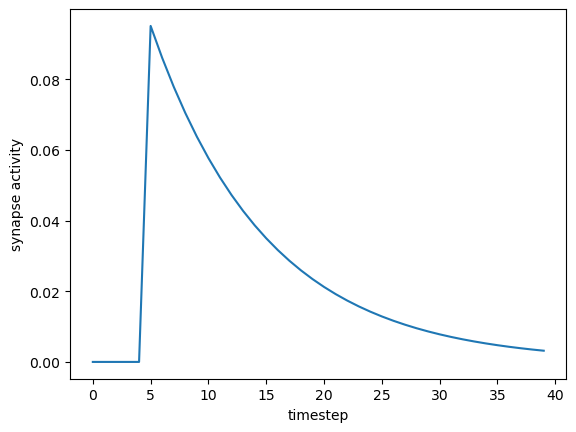

In [40]:
activity - np.zeros(1)
activity_syn = np.zeros(1)

dt = 0.001    # length of a timestep
tau = 0.010   # time constant for the synapse
alpha = 1-np.exp(-dt/tau)
record = []
for i in range(40):
    activity = 0
    if i == 5:
        activity = 1
    activity_syn = activity_syn + alpha * (activity - activity_syn)   
    record.append(activity_syn)

import matplotlib.pyplot as plt
plt.plot(record)
plt.xlabel('timestep')
plt.ylabel('synapse activity')
plt.show()

While our winner-take-all model is not spiking, we can still add this synapse model to the system.  This would be done as follows:

In [41]:
record = []             
activity = np.zeros(N)        # the raw output from the neuron
activity_syn = np.zeros(N)    # the output from the synapse
for i in range(20):
    activity = np.clip(input_values + w @ activity_syn, 0, 1)  # note we use activity_syn here, not activity
    activity_syn += alpha * (activity - activity_syn)          # implement the synapse 

    record.append(activity_syn)    


**3. a) [1 mark]** Test the winner-take-all model with a synapse time constant of 10 milliseconds, inhibition of -0.9, and excitation of 1 against all the data in `X`, running it for 20 timesteps (with each timestep being 1 millisecond).  What proportion of time does it get the correct answer?  Repeat this for differet synapse time constants (try 0.001, 0.002, 0.005, 0.01, and 0.02 seconds) and generate a plot showing the accuracy as you change the time constant.


In [42]:
# Go back to basic example
w = np.zeros((N,N))
w[:] = -0.9   # set the inhibition amount everywhere
for i in range(N):
    w[i,i] = 1   # set the excitatory connection
    
print(w)

[[ 1.  -0.9 -0.9 -0.9]
 [-0.9  1.  -0.9 -0.9]
 [-0.9 -0.9  1.  -0.9]
 [-0.9 -0.9 -0.9  1. ]]


In [43]:
def find_alpha(time_constant):
    dt = 0.001    # length of a timestep
    tau = time_constant   # time constant for the synapse
    alpha = 1-np.exp(-dt/tau)
    return alpha

In [44]:
def synapse_winner_take_all(input_values, w, synapse_time_constant=0.01, iterations=20):
    synapse_alpha = find_alpha(synapse_time_constant)
    record = []             
    activity = np.zeros(N)        # the raw output from the neuron
    activity_syn = np.zeros(N)    # the output from the synapse
    for i in range(iterations):
        activity = np.clip(input_values + w @ activity_syn, 0, 1)  # note we use activity_syn here, not activity
        # activity = np.clip(input_values + w @ activity, 0, 1)
        activity_syn += synapse_alpha * (activity - activity_syn)          # implement the synapse 
        # print(activity_syn)
        record.append(activity_syn)
    return record[-1], record

[0. 1. 0. 0.]


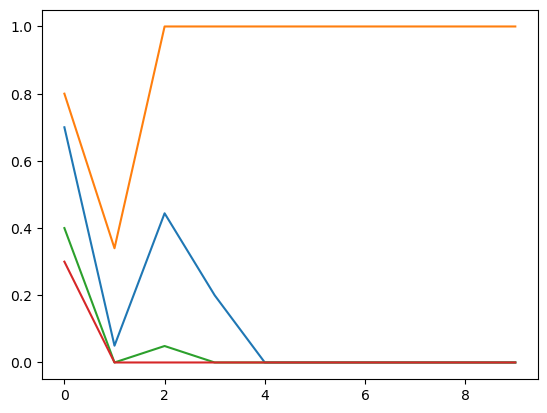

In [45]:
inputs = np.array([0.7, 0.8, 0.4, 0.3])
output, record = winner_take_all(inputs, w)
print(output)
plt.plot(record)

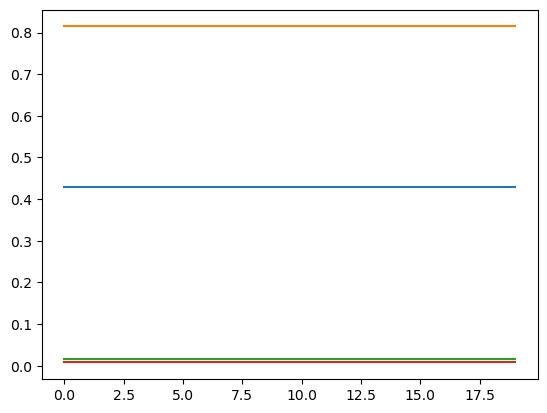

In [46]:
inputs = np.array([0.7, 0.8, 0.4, 0.3])
output, record = synapse_winner_take_all(inputs, w)
plt.plot(record)

In [56]:
def test_synapse_wta(synapse_alpha, excit_value=1, inhit_value=-0.9, tolerance=0.01):
  w = np.zeros((N,N))
  w[:] = inhit   # set the inhibition amount everywhere
  for i in range(N):
      w[i,i] = excit   # set the excitatory connection
  correct = 0
  almost_correct = 0
  for input_values in X:
      output, _ = synapse_winner_take_all(input_values, w, synapse_alpha)
      target = np.zeros(N)
      target[np.argmax(input_values)] = 1
      if np.all(target == output):
          correct += 1
      elif np.allclose(target, output, atol=tolerance):
          almost_correct += 1
  accuracy = correct / M
  adjusted_accuracy = (correct + almost_correct) / M
  return accuracy, adjusted_accuracy

In [57]:
synapse_constants = [0.001, 0.002, 0.005, 0.01, 0.02]
accuracies = []
adjusted_accuracies = []
for alpha in synapse_constants:
    print('Testing with synapse_alpha:', alpha)
    accuracy, adjusted_accuracy = test_synapse_wta(alpha)
    print('Accuracy:', accuracy)
    print('Adjusted Accuracy:', adjusted_accuracy)
    accuracies.append(accuracy)
    adjusted_accuracies.append(adjusted_accuracy)

Testing with synapse_alpha: 0.001
Accuracy: 0.0
Adjusted Accuracy: 0.9962
Testing with synapse_alpha: 0.002
Accuracy: 0.0
Adjusted Accuracy: 0.9571
Testing with synapse_alpha: 0.005
Accuracy: 0.0
Adjusted Accuracy: 0.0
Testing with synapse_alpha: 0.01
Accuracy: 0.0
Adjusted Accuracy: 0.0
Testing with synapse_alpha: 0.02
Accuracy: 0.0
Adjusted Accuracy: 0.0


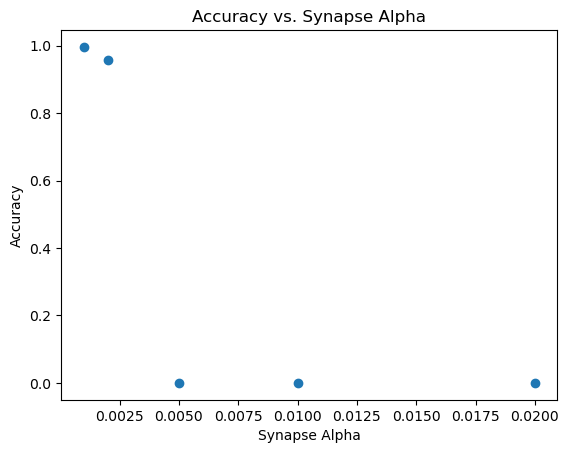

In [58]:
# Plot accuracy vs. synapse_alpha
plt.scatter(synapse_constants, adjusted_accuracies)
plt.xlabel('Synapse Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Synapse Alpha')
plt.show()

We find that none of the synapse models reach exactly correct values but if we compare with some tolerance for error than we see that the lower time constants, 0.001 and 0.002 perform quite well.

**3. b) [2 marks]** Try improving the model by adjusting the synaptic time constant, the amount of inhibition and the amount of excitation.  Can you improve the proportion of time the model produces the correct output?  To simplify your experimentation, keep the number of timesteps as 20.  As a hint, you should be able to get the model close to 99% accuracy!  This is an example of adding a biological detail to a model and having it improve its performance.


In [59]:
synapse_constants = [0.0001, 0.0005, 0.001, 0.002, 0.005]
excit_values = [0.9, 0.95, 1, 1.05, 1.1]
inhit_values = [-0.9, -0.95, -1, -1.05, -1.1]
accuracies = []
adjusted_accuracies = []
for alpha in synapse_constants:
    for excit in excit_values:
        for inhit in inhit_values:
            print('Testing with synapse_alpha:', alpha, 'excit:', excit, 'inhit:', inhit)
            accuracy, adjusted_accuracy = test_synapse_wta(alpha, excit, inhit)
            print('Accuracy:', accuracy)
            print('Adjusted Accuracy:', adjusted_accuracy)
            accuracies.append(accuracy)
            adjusted_accuracies.append(adjusted_accuracy)

Testing with synapse_alpha: 0.0001 excit: 0.9 inhit: -0.9
Accuracy: 0.0
Adjusted Accuracy: 0.8437
Testing with synapse_alpha: 0.0001 excit: 0.9 inhit: -0.95
Accuracy: 0.0
Adjusted Accuracy: 0.8235
Testing with synapse_alpha: 0.0001 excit: 0.9 inhit: -1
Accuracy: 0.0
Adjusted Accuracy: 0.7804
Testing with synapse_alpha: 0.0001 excit: 0.9 inhit: -1.05
Accuracy: 0.0
Adjusted Accuracy: 0.7278
Testing with synapse_alpha: 0.0001 excit: 0.9 inhit: -1.1
Accuracy: 0.0
Adjusted Accuracy: 0.6679
Testing with synapse_alpha: 0.0001 excit: 0.95 inhit: -0.9
Accuracy: 0.0
Adjusted Accuracy: 0.852
Testing with synapse_alpha: 0.0001 excit: 0.95 inhit: -0.95
Accuracy: 0.0
Adjusted Accuracy: 0.8408
Testing with synapse_alpha: 0.0001 excit: 0.95 inhit: -1
Accuracy: 0.0
Adjusted Accuracy: 0.8073
Testing with synapse_alpha: 0.0001 excit: 0.95 inhit: -1.05
Accuracy: 0.0
Adjusted Accuracy: 0.7564
Testing with synapse_alpha: 0.0001 excit: 0.95 inhit: -1.1
Accuracy: 0.0
Adjusted Accuracy: 0.7027
Testing with syn

In [65]:
print(f"Total num of accuracies: {len(accuracies)}")
print(f"Total num of adjusted accuracies: {len(adjusted_accuracies)}")

# Find highest accuracy
max_accuracy = np.max(adjusted_accuracies)
print('Max accuracy:', max_accuracy)
# Find indices of highest accuracy
max_index = np.argmax(adjusted_accuracies)
print('Max index:', max_index)

synapse_index = max_index // (len(excit_values) * len(inhit_values))
excit_index = (max_index % (len(excit_values) * len(inhit_values))) // len(inhit_values)
inhit_index = max_index % len(inhit_values)

# # Find excit and inhit values that produced highest accuracy
best_synapse_alpha = synapse_constants[synapse_index]
best_excit = excit_values[excit_index]
best_inhit = inhit_values[inhit_index]
print('Best synapse_alpha:', best_synapse_alpha)
print('Best excit:', best_excit)
print('Best inhit:', best_inhit)

Total num of accuracies: 125
Total num of adjusted accuracies: 125
Max accuracy: 0.9976
Max index: 59
Best synapse_alpha: 0.001
Best excit: 0.95
Best inhit: -1.1


We see that the performance improves as high as 99.76% when we adjust the parameters to a time constant of 0.001, excitation value of 0.95, and inhibition value of -1.1.